In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
from joblib import Parallel, delayed
import numpy as np
import re
from typing import List
import geopandas as gp
gp.options.io_engine = "pyogrio"
from scipy.spatial import cKDTree
from shapely.ops import transform
from shapely.geometry import Point, Polygon
import pyproj

In [2]:
ws1 = Path("/home/aschneuwl/workspace/")
ws2 = Path("/mnt/wks3/aschneuwl/workspace/")

# Station Metadata

In [3]:
LONG_LAT_PATTERN = r"(\d+)°(\d+)'"

def read_legend_data(fpath: Path) -> pd.DataFrame:
    print(fpath)
    """
    Reads Legend From MeteoSuisse Data
    """
    records = []
    
    with open(fpath, encoding='cp1252') as fp:
        # only from line 33 and below
        lines = fp.readlines()[32:]

    for l in lines:
        if l.strip() == "":
            break
        
        m = re.match(r"(\S+)\s+(.+?)\s+(ure[a-zA-Z0-9]{5})\s{2,}(.+?)\s{1,}(\d+°\d+\'\/\d+°\d+\')\s+(\d+\/\d+)\s+(\d+)", l)
        if m is None:
            print(l)
        station = m.group(1)
        name = m.group(2).strip()
        param = m.group(3).strip() 
        source = m.group(4).strip()
        location_long_lat = m.group(5).strip()
        location_km = m.group(6).strip()
        height = int(m.group(7).strip())
        
        #station = l[0:10].strip()
        #name = l[10:47].strip()
        #param = l[47:64].strip()
        #source = l[64:115].strip()
        
        #location_long_lat = l[115:140].strip()
        #print(location_long_lat)
        long, lat = location_long_lat.split("/")
        
        match = re.search(LONG_LAT_PATTERN, long)
        long_deg, long_min = int(match.group(1)), int(match.group(2))
        
        match = re.search(LONG_LAT_PATTERN, lat)
        lat_deg, lat_min = int(match.group(1)), int(match.group(2))
        
        # location_km = l[127:157].strip()
        location_km_long, location_km_lat = location_km.split("/")
        
        #height = int(l[157:171].strip())

        record = {"stationId": station,
                 "stationName": name,
                 "paramName": param,
                 "stationSource": source,
                 "locationLongLat": location_long_lat,
                 "locationLong": long,
                 "locationLat": lat,
                 "locationLongDeg": long_deg,
                 "locationLongMin": long_min,
                 "locationLatDeg": lat_deg,
                 "locationLatMin": lat_min,
                 "locationKmLong": location_km_long,
                 "locationKmLat": location_km_lat,
                 "height": height}
        
        records.append(record)

    
    df = pd.DataFrame.from_dict(records)
    df["locationLongDec"] = df["locationLongDeg"] + (df["locationLongMin"] / 60)
    df["locationLatDec"] = df["locationLatDeg"] + (df["locationLatMin"] / 60)
    df["height_100"] = df["height"] * 100

    return df

In [4]:
legend_files_min_max = list(Path("/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2").glob("*_legend.txt"))
legend_files_mean = list(Path("/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg").glob("*_legend.txt"))
legend_files_hourly = list(Path("/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumhourly").glob("*_legend.txt"))
legend_files = legend_files_min_max + legend_files_mean + legend_files_hourly

In [42]:
meteosuisse_legend_data = pd.concat([read_legend_data(Path(f)) for f in legend_files]).drop_duplicates()

/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123118_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123099_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123110_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123098_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123131_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123096_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123120_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123102_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123104_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123122_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123090_legend.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123108_legend.txt
/home/aschneuwl/workspace/da

In [43]:
def prepare_weather_stations(station_df: pd.DataFrame) -> gp.GeoDataFrame:
    """
    Prepare MeteoSuisse Station Metadata (for manually downloaded weather data from the IDAWEB portal)
    """
    station_df = gp.GeoDataFrame(
    station_df,
    geometry=[Point(lo,la) for lo,la in zip(station_df["locationLongDec"].values, station_df["locationLatDec"].values)],
    crs="EPSG:4326"
    )
    
    station_df = station_df.drop("paramName", axis=1)
    station_df = station_df.drop_duplicates().reset_index()
    
    lv95 = pyproj.CRS('EPSG:2056')
    wgs84 = pyproj.CRS('EPSG:4326')
    #municipalities.geometry.simplify(0.5)
    project = pyproj.Transformer.from_crs(wgs84, lv95, always_xy=True).transform
    station_df["lv95"] = None
    
    for i, shape in station_df.iterrows():
        if shape.geometry is not None:
            shape.lv95 = transform(project, shape.geometry)
            station_df.iloc[i] = shape
    
    station_df["longitude_m"] = station_df["lv95"].apply(lambda p: p.x)
    station_df["latitude_m"] = station_df["lv95"].apply(lambda p: p.y)
    station_df = station_df.drop("lv95",axis=1)

    return station_df

In [49]:
all_stations_metadata = prepare_weather_stations(meteosuisse_legend_data)

In [46]:
all_stations_metadata.to_parquet(ws2 /Path("data/preprocessed/meteo") / "meteosuisse_stations_meta.parquet")

In [35]:
all_stations_metadata = gp.read_parquet(ws2 /Path("data/preprocessed/meteo") / "meteosuisse_stations_meta.parquet")

# Station Metadata Sanity Checks

In [4]:
import pandas as pd

In [47]:
all_stations_metadata = pd.read_parquet("meteosuisse_stations_meta.parquet")

In [50]:
all_stations_metadata[all_stations_metadata.stationId == "LMA"]

,index,stationId,stationName,stationSource,locationLongLat,locationLong,locationLat,locationLongDeg,locationLongMin,locationLatDeg,locationLatMin,locationKmLong,locationKmLat,height,locationLongDec,locationLatDec,height_100,geometry,longitude_m,latitude_m
146,7,LMA,Locarno / Magadino,Schweizer Armee - Luftwaffe,8°52'/46°10',8°52',46°10',8,52,46,10,710890,113610,198,8.866667,46.166667,19800,POINT (8.86667 46.16667),2.710292e+06,1.113802e+06


In [51]:
all_stations_metadata[all_stations_metadata.stationId == "GRA"]

,index,stationId,stationName,stationSource,locationLongLat,locationLong,locationLat,locationLongDeg,locationLongMin,locationLatDeg,locationLatMin,locationKmLong,locationKmLat,height,locationLongDec,locationLatDec,height_100,geometry,longitude_m,latitude_m
302,6,GRA,Fribourg / Grangeneuve,MeteoSchweiz,7°07'/46°46',7°07',46°46',7,7,46,46,575183,180076,650,7.116667,46.766667,65000,POINT (7.11667 46.76667),2.575406e+06,1.179549e+06


In [52]:
all_stations_metadata[all_stations_metadata.stationName == "Locarno / Monti"]

,index,stationId,stationName,stationSource,locationLongLat,locationLong,locationLat,locationLongDeg,locationLongMin,locationLatDeg,locationLatMin,locationKmLong,locationKmLat,height,locationLongDec,locationLatDec,height_100,geometry,longitude_m,latitude_m
420,7,OTL,Locarno / Monti,MeteoSchweiz,8°47'/46°10',8°47',46°10',8,47,46,10,704166,114316,366,8.783333,46.166667,36600,POINT (8.78333 46.16667),2.703856e+06,1.113689e+06


In [53]:
all_stations_metadata.stationSource.unique()

array(['MeteoSchweiz', 'Kanton Thurgau', 'Eidg. Forschungsanstalt WSL',
       'Kachelmannwetter GmbH', 'Bundesamt für Umwelt', 'DTN Schweiz AG',
       'WSL-Institut für Schnee- und Lawinenforschung SLF',
       'Swiss Permafrost Monitoring Network',
       'Schweizerischer Nationalpark',
       "Repubblica e Cantone Ticino; Dipartimento del territorio; Divisione delle costruzioni; Ufficio dei corsi d'acqua",
       'Repubblica e Cantone Ticino; Dipartimento del territorio; Divisione ambiente; Sezione protezione aria, acqua e suolo; Ufficio del monitoraggio ambientale',
       'Schweizer Armee - Luftwaffe', 'unknown', 'inNET Monitoring AG',
       'Botanisches Institut der Universität Basel',
       'République et canton de Neuchâtel',
       'Kanton Aargau; Departement Bau, Verkehr und Umwelt; Abteilung für Umwelt',
       'MétéoSuisse', 'Lufthygieneamt beider Basel',
       'Deutscher Wetterdienst',
       "Servizio Meteorologico dell'Aeronautica Militare", 'Ostluft',
       'Kanton

In [54]:
def date_time_helper(val: str) -> datetime:
    try:
        date = datetime.strptime(val, '%Y%m%d')
    except:
        date = datetime.strptime(val, '%Y%m%d%H')

    return date

In [14]:
def read_meteo_suisse_data(fpath: Path) -> pd.DataFrame:
    """
    Reads data downloaded from the MeteoSuisse Portal
    """
    print(fpath)
    with open(fpath) as fp:
        lines = fp.readlines()
    
    new_lines = []
    columns = None
    frames = []
    
    for l in lines:
        l = l.strip()
        if l.startswith("stn"):
            columns = l.split(";")
        elif l == "" and len(new_lines) != 0:
            df = pd.DataFrame(new_lines, columns = columns)
            df["time"] = df.time.apply(lambda x: date_time_helper(x))
            frames.append(df)
            columns = None
            new_lines = []
        elif l != "":
            new_lines.append(l.split(";"))

    df = pd.concat(frames)
    column_mapping = {"ure200dx": "relHumDMax", "ure200dn": "relHumDMin",  "ure200hs": "relHumH", "stn": "stationId", "time": "time", "ure200d0": "relHumDMean"}
    df.columns = [column_mapping[c] for c in df.columns]

    return df

In [15]:
def extract_col_from_frames(frames, col: str):
    """
    """
    new_frames = []
    for df in frames:
        if col in df.columns:
            new_frames.append(df[["stationId", "time", col]])
    
    new_frame = pd.concat(new_frames).set_index(["stationId", "time"]).replace('-', np.nan).dropna()
    
    return new_frame

# Min Max Relative Humidity Station Data

In [56]:
files = list(Path("/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2").glob("*_data.txt"))

In [57]:
dfs = [read_meteo_suisse_data(f) for f in files]
cols = ["relHumDMax", "relHumDMin", "relHumH"]
col_frames = [extract_col_from_frames(dfs, c) for c in cols]

/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123096_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123132_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123129_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123092_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123102_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123099_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123123_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123122_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123114_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123110_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123106_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhum2/order_123095_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/rel

In [58]:
merged_df = col_frames[0]

# Iteratively merge remaining DataFrames
for df in col_frames[1:]:
    merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='outer')

In [60]:
merged_df = merged_df.reset_index()
merged_df["relHumDMax"] = pd.to_numeric(merged_df.relHumDMax)
merged_df["relHumDMin"] = pd.to_numeric(merged_df.relHumDMin)
merged_df["relHumH"] = pd.to_numeric(merged_df.relHumH)

In [61]:
station_min_max = merged_df[["stationId", "time", "relHumDMax", "relHumDMin"]].dropna(subset=["relHumDMax", "relHumDMin"], how='any')

In [63]:
station_min_max = station_min_max[station_min_max['stationId'] != "MMIBG"]
station_min_max = station_min_max[station_min_max['stationId'] != "LMA"]

In [104]:
station_min_max.drop_duplicates(inplace=True)
station_min_max.reset_index(drop=True, inplace=True)

In [105]:
station_min_max.reset_index(drop=True).to_parquet(ws2 / Path("data/preprocessed/meteo") / "relHumD_min_max_meteosuisse_stations.parquet")

In [106]:
station_min_max

,stationId,time,relHumDMax,relHumDMin
0,ABO,2004-02-01,58.5,14.8
1,ABO,2004-02-02,45.6,12.3
2,ABO,2004-02-03,57.1,31.2
3,ABO,2004-02-04,55.1,20.7
4,ABO,2004-02-05,54.9,20.3
...,...,...,...,...
3015958,ZER,2024-03-27,100.0,75.7
3015959,ZER,2024-03-28,95.0,68.7
3015960,ZER,2024-03-29,80.4,27.2
3015961,ZER,2024-03-30,98.1,34.2


# Daily Mean Relative Humidity Station Data

In [77]:
mean_files = list(Path("/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg").glob("*_data.txt"))
mean_dfs = [read_meteo_suisse_data(f) for f in mean_files]
mean_cols = ["relHumDMean"]
mean_col_frames = [extract_col_from_frames(mean_dfs, c) for c in mean_cols]

/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg/order_123199_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg/order_123200_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg/order_123201_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg/order_123195_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg/order_123198_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg/order_123196_data.txt
/home/aschneuwl/workspace/data/meteo/meteosuisse/relhumavg/order_123197_data.txt


In [84]:
mean_merged_df = mean_col_frames[0]

# Iteratively merge remaining DataFrames
for df in mean_col_frames[1:]:
    mean_merged_df = pd.merge(mean_merged_df, df, left_index=True, right_index=True, how='outer')

In [85]:
mean_merged_df = mean_merged_df.reset_index()
mean_merged_df["relHumDMean"] = pd.to_numeric(mean_merged_df.relHumDMean)

In [90]:
station_mean = mean_merged_df[["stationId", "time", "relHumDMean"]].dropna(subset=["relHumDMean"], how='any')

In [91]:
station_mean = station_mean[station_mean['stationId'] != "MMIBG"]
station_mean = station_mean[station_mean['stationId'] != "LMA"]

In [107]:
station_mean.drop_duplicates(inplace=True)
station_mean.reset_index(drop=True, inplace=True)

In [108]:
station_mean.reset_index(drop=True).to_parquet(ws2 / Path("data/preprocessed/meteo") / "relHumD_mean_meteosuisse_stations.parquet")

In [109]:
station_mean

,stationId,time,relHumDMean
0,MMAEU,2012-11-23,92.1
1,MMAEU,2012-11-24,81.9
2,MMAEU,2012-11-25,84.2
3,MMAEU,2012-11-26,94.2
4,MMAEU,2012-11-27,96.7
...,...,...,...
4523263,SIR,2017-11-30,70.4
4523264,SIR,2017-12-01,75.8
4523265,SIR,2017-12-02,71.8
4523266,SIR,2017-12-03,71.4


In [5]:
station_mean = pd.read_parquet(ws2 / Path("data/preprocessed/meteo") / "relHumD_mean_meteosuisse_stations.parquet")

In [15]:
station_mean[station_mean.time.dt.year == 1983].stationId.nunique()

155

In [18]:
station_mean[station_mean.time.dt.year > 2023].stationId.nunique()

518

In [111]:
merged_daily_station_data = pd.merge(station_min_max, station_mean, on=['stationId', 'time'], how='outer')

In [126]:
def check_if_days_missing(df: pd.DataFrame):
    # Find the minimum and maximum dates
    min_date = df['time'].min()
    max_date = df['time'].max()
    
    # Generate the complete date range
    complete_date_range = pd.date_range(start=min_date, end=max_date)
    
    # Check if all days are covered
    missing_dates = complete_date_range.difference(df['time'])
    
    if missing_dates.empty:
        print("All days are covered between the min and max date.")
    else:
        print("The following dates are missing:", missing_dates)

In [127]:
check_if_days_missing(merged_daily_station_data.dropna(how="any"))

All days are covered between the min and max date.


In [131]:
merged_daily_station_data.dropna(how="any").reset_index(drop=True).to_parquet(ws2 / Path("data/preprocessed/meteo") / "relHumD_min_max_mean_meteosuisse_stations.parquet")

# Station Data / Metadata Distribution Analysis

In [2]:
import pandas as pd

<Axes: >

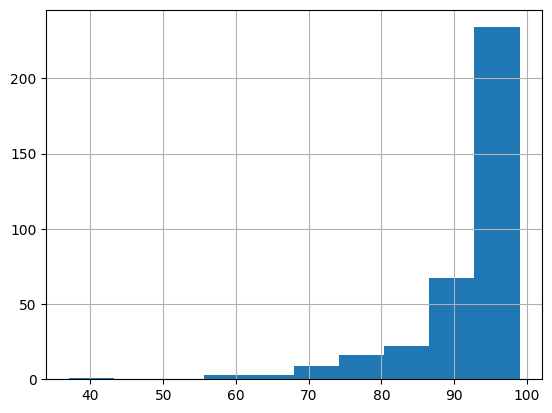

In [44]:
station_min_max[(station_min_max.stationId == "LMA") & (station_min_max.time.dt.year == 2023)].relHumDMax.hist()

<Axes: >

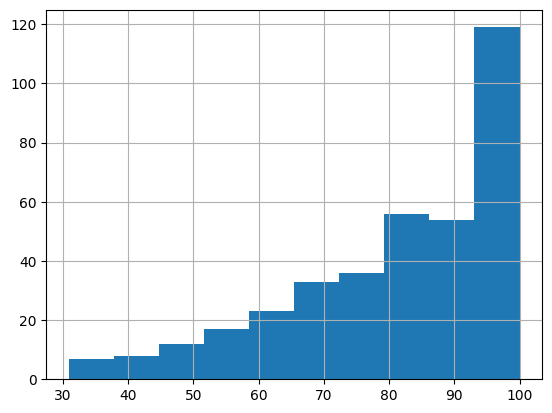

In [45]:
station_min_max[(station_min_max.stationId == "OTL") & (station_min_max.time.dt.year == 2023)].relHumDMax.hist()

<Axes: >

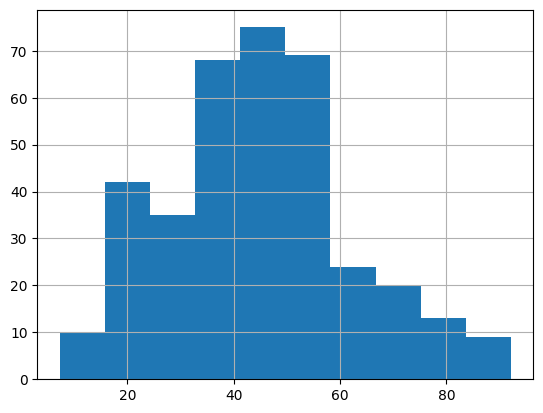

In [41]:
station_min_max[(station_min_max.stationId == "OTL") & (station_min_max.time.dt.year == 2023)].relHumDMin.hist()

<Axes: >

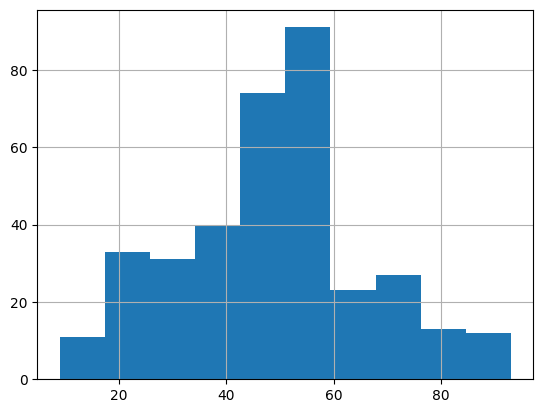

In [42]:
station_min_max[(station_min_max.stationId == "LMA") & (station_min_max.time.dt.year == 2023)].relHumDMin.hist()

In [ ]:
station_min_max[(station_min_max.stationId == "MMIBG") & (station_min_max.time.dt.year == 2023)].relHumDMax.hist()

In [6]:
station_min_max = pd.read_parquet("relHumD_meteosuisse_stations.parquet")


,stationId,time,relHumDMax,relHumDMin
943069,MMIBG,2012-11-27,96.1,87.8
943070,MMIBG,2012-11-28,95.4,88.4
943071,MMIBG,2012-11-29,91.5,27.8
943072,MMIBG,2012-11-30,71.3,36.0
943073,MMIBG,2012-12-01,82.2,63.8
...,...,...,...,...
946431,MMIBG,2024-03-27,92.5,85.7
946432,MMIBG,2024-03-28,93.3,81.9
946433,MMIBG,2024-03-29,96.0,84.1
946434,MMIBG,2024-03-30,96.0,83.1


<Axes: xlabel='time'>

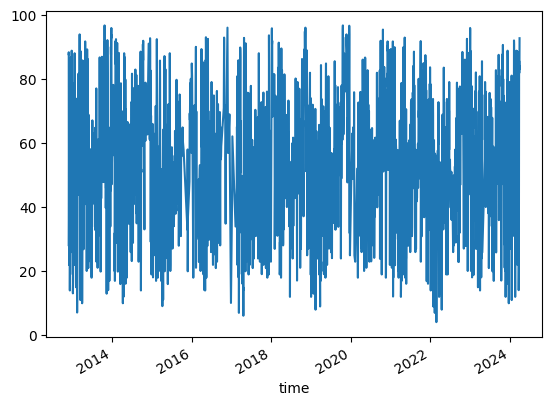

In [11]:
station_min_max[station_min_max["stationId"] == "MMIBG"].set_index("time")["relHumDMin"].plot()

# Daily Max/Min Relative Humidity

In [553]:
def calculate_gaps(group):
    # determine full date range for group
    full_range = pd.date_range(start=group['time'].min(), end=group['time'].max(), freq='D')
    
    # available dates in current group
    actual_dates = group['time'].unique()
    
    # gaps
    gaps = len(full_range.difference(actual_dates))
    
    return gaps

gaps_per_station = station_min_max.groupby("stationId").apply(calculate_gaps).reset_index(name='gaps')

/tmp/ipykernel_500694/1713555756.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps_per_station = station_min_max.groupby("stationId").apply(calculate_gaps).reset_index(name='gaps')


array([[<Axes: title={'center': 'gaps'}>]], dtype=object)

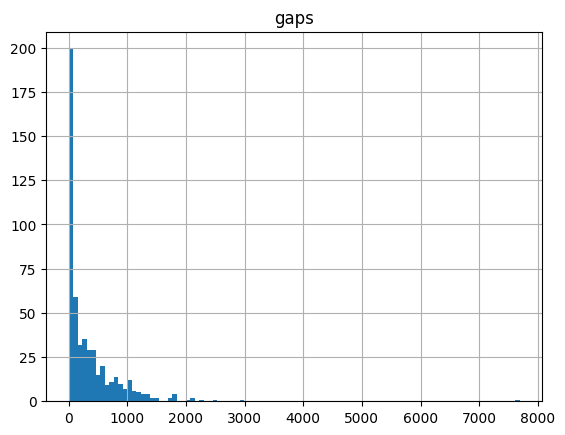

In [554]:
gaps_per_station.hist(bins=100)

<Axes: >

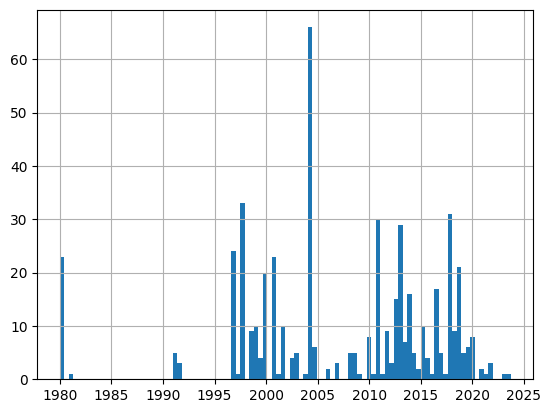

In [555]:
station_min_max.groupby("stationId").time.min().hist(bins=100)

<Axes: >

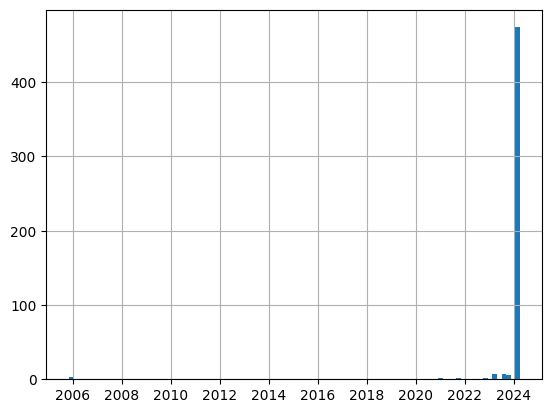

In [556]:
station_min_max.groupby("stationId").time.max().hist(bins=100)

In [557]:
station_active = list(station_min_max[station_min_max.time == "2023-12-31"].stationId.unique())

In [558]:
station_min_max_active = station_min_max[station_min_max.stationId.isin(station_active)]

In [559]:
station_min_max_active

,stationId,time,relHumDMax,relHumDMin
176967,ABO,2004-02-01,58.5,14.8
176991,ABO,2004-02-02,45.6,12.3
177015,ABO,2004-02-03,57.1,31.2
177039,ABO,2004-02-04,55.1,20.7
177063,ABO,2004-02-05,54.9,20.3
...,...,...,...,...
51232283,ZER,2024-03-27,100.0,75.7
51232307,ZER,2024-03-28,95.0,68.7
51232331,ZER,2024-03-29,80.4,27.2
51232355,ZER,2024-03-30,98.1,34.2


In [560]:
gaps_per_station_active = station_min_max_active.groupby("stationId").apply(calculate_gaps).reset_index(name='gaps')

/tmp/ipykernel_500694/2602213066.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps_per_station_active = station_min_max_active.groupby("stationId").apply(calculate_gaps).reset_index(name='gaps')


<Axes: >

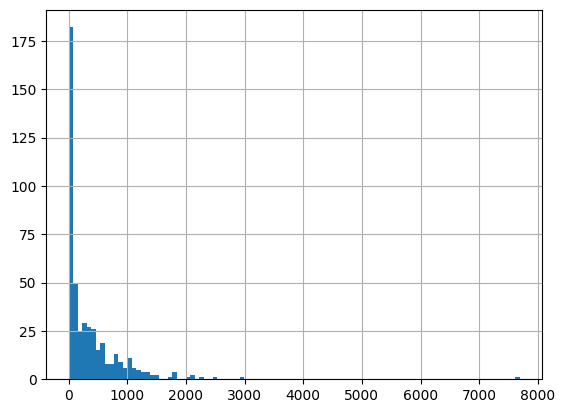

In [561]:
gaps_per_station_active.gaps.hist(bins=100)

In [565]:
gaps_per_station_active[gaps_per_station_active.gaps == 0]

,stationId,gaps
3,ALT,0
11,BER,0
27,CGI,0
50,ELM,0
52,ENG,0
56,FLU,0
60,GES,0
65,GOS,0
86,KLO,0
87,KOP,0


In [566]:
gaps_per_station_active[gaps_per_station_active.gaps <= 500]

,stationId,gaps
0,ABO,11
1,AIG,5
3,ALT,0
4,AND,2
5,ANT,4
...,...,...
458,WSLVOB,496
459,WSLVOF,271
460,WSLVSB,372
461,WYN,2


In [567]:
c = list(gaps_per_station_active[gaps_per_station_active.gaps <= 500].stationId.unique())
candidates = station_min_max[station_min_max.stationId.isin(c)]

In [571]:
candidates[candidates.time == "1980-01-01"].stationId.nunique()

20

In [572]:
len(c)

351

In [573]:
candidates

,stationId,time,relHumDMax,relHumDMin
176967,ABO,2004-02-01,58.5,14.8
176991,ABO,2004-02-02,45.6,12.3
177015,ABO,2004-02-03,57.1,31.2
177039,ABO,2004-02-04,55.1,20.7
177063,ABO,2004-02-05,54.9,20.3
...,...,...,...,...
51232283,ZER,2024-03-27,100.0,75.7
51232307,ZER,2024-03-28,95.0,68.7
51232331,ZER,2024-03-29,80.4,27.2
51232355,ZER,2024-03-30,98.1,34.2


<Axes: >

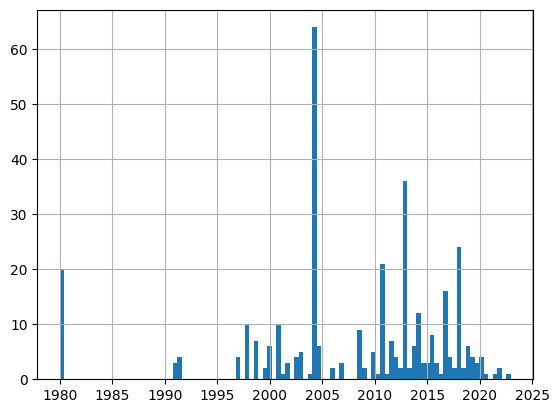

In [574]:
candidates.groupby("stationId").time.min().hist(bins=100)

<Axes: >

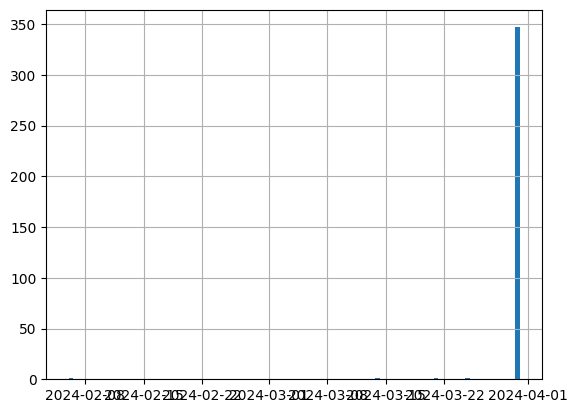

In [575]:
candidates.groupby("stationId").time.max().hist(bins=100)

In [576]:
candidates = all_stations_metadata.merge(candidates.groupby("stationId").time.min().dt.year.reset_index(), on="stationId", how="right")

In [634]:
candidates

,index,stationId,stationName,stationSource,locationLongLat,locationLong,locationLat,locationLongDeg,locationLongMin,locationLatDeg,...,locationKmLong,locationKmLat,height,locationLongDec,locationLatDec,height_100,geometry,longitude_m,latitude_m,time
0,0,ABO,Adelboden,MeteoSchweiz,7°34'/46°30',7°34',46°30',7,34,46,...,609372,148939,1321,7.566667,46.500000,132100,POINT (7.56667 46.50000),2.609828e+06,1.149862e+06,2004
1,0,AIG,Aigle,MeteoSchweiz,6°55'/46°20',6°55',46°20',6,55,46,...,560404,130713,381,6.916667,46.333333,38100,POINT (6.91667 46.33333),2.559807e+06,1.131461e+06,2004
2,0,ALT,Altdorf,MeteoSchweiz,8°37'/46°53',8°37',46°53',8,37,46,...,690180,193564,437,8.616667,46.883333,43700,POINT (8.61667 46.88333),2.689789e+06,1.193142e+06,2004
3,1,AND,Andeer,MeteoSchweiz,9°26'/46°37',9°26',46°37',9,26,46,...,752691,164038,987,9.433333,46.616667,98700,POINT (9.43333 46.61667),2.752777e+06,1.164765e+06,2008
4,3,ANT,Andermatt,MeteoSchweiz,8°35'/46°38',8°35',46°38',8,35,46,...,687444,165044,1434,8.583333,46.633333,143400,POINT (8.58333 46.63333),2.687654e+06,1.165315e+06,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,39,WSLVOB,Vordemwald Bestand,Eidg. Forschungsanstalt WSL,7°53'/47°16',7°53',47°16',7,53,47,...,633932,235983,482,7.883333,47.266667,48200,POINT (7.88333 47.26667),2.633655e+06,1.235180e+06,2018
370,42,WSLVOF,Vordemwald Freiland,Eidg. Forschungsanstalt WSL,7°55'/47°16',7°55',47°16',7,55,47,...,635732,235431,486,7.916667,47.266667,48600,POINT (7.91667 47.26667),2.636177e+06,1.235195e+06,2018
371,156,WSLVSB,Visp Bestand,Eidg. Forschungsanstalt WSL,7°51'/46°18',7°51',46°18',7,51,46,...,632260,127364,698,7.850000,46.300000,69800,POINT (7.85000 46.30000),2.631695e+06,1.127704e+06,2018
372,120,WYN,Wynau,MeteoSchweiz,7°47'/47°15',7°47',47°15',7,47,47,...,626404,233848,421,7.783333,47.250000,42100,POINT (7.78333 47.25000),2.626095e+06,1.233289e+06,2004


In [22]:
list(candidates.stationId.values)

NameError: name 'candidates' is not defined

In [23]:
def assign_stations_to_localities(stations_df: gp.GeoDataFrame, localities: gp.GeoDataFrame, station_list: List[str] = None, closest=True) -> gp.GeoDataFrame:
    if station_list != None:
        stations_df = stations_df[stations_df["stationId"].isin(station_list)]
    
    if closest:
        # Bucheli et al. Method
        
        tree = cKDTree(stations_df.apply(lambda x: (x.longitude_m, x.latitude_m, x.height_100), axis=1).tolist())
        distances, indices = tree.query(localities.apply(lambda l: (l.longitude_x, l.latitude_y, l.altitude_100), axis=1).tolist())
        
        rows = stations_df.iloc[indices]
        rows["station_geometry"] = rows.geometry
        
        localities = pd.concat([localities.reset_index(), rows.reset_index(drop=True).drop("geometry", axis=1)], axis=1)
    else:
        stations_df["station_geometry"] = stations_df.geometry
        localities = localities.sjoin(stations_df)
        
    
    return localities

In [19]:
localities_fpath = ws2 / Path("data/preprocessed/geo/swiss_localities_with_altitudes.parquet")

/tmp/ipykernel_214647/369385914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["station_geometry"] = rows.geometry


<Axes: >

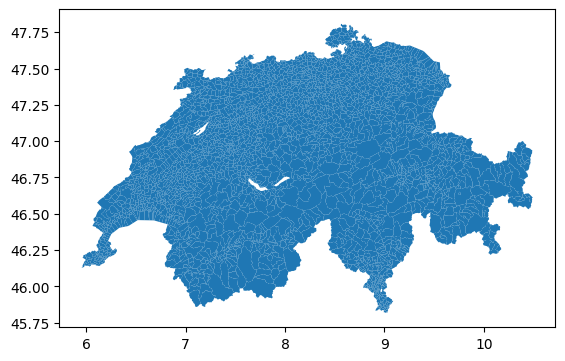

In [30]:
localized_stations = assign_stations_to_localities(all_stations_metadata, gp.read_parquet(localities_fpath), closest=True)
localized_stations.plot()

<Axes: >

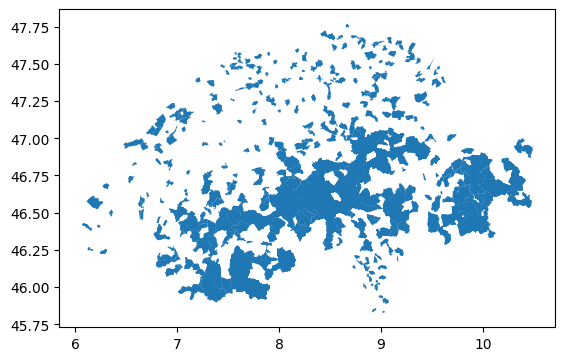

In [139]:
localized_stations = assign_stations_to_localities(all_stations_metadata, gp.read_parquet(localities_fpath), closest=False)
localized_stations.plot()

In [142]:
localized_stations.shape

(631, 37)

/home/aschneuwl/.pyenv/versions/3.12.3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

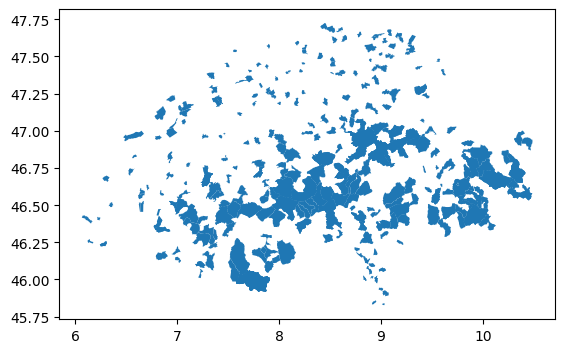

In [629]:
localized_stations = assign_stations_to_localities(all_stations_metadata, gp.read_parquet("../AMTOVZ_ZIP_wgs84.parquet"), list(candidates.stationId.values), closest=False)
localized_stations.plot()

In [ ]:
fig = px.choropleth_mapbox(station_zip_mapping, geojson=localities_swiss.drop("location_center", axis=1), featureidkey="properties.ZIP4",
                           locations='ZIP4', 
                           color='n_measurements',
                           mapbox_style="carto-positron",
                           zoom=6.3, 
                           center = {"lat": 46.8, "lon": 8.5},
                           opacity=0.5,
                           width=1000,
                           height=750,
                           hover_data=["stationId"],
                           labels={"n_measurements": "Number of Humidity Measurements", "ZIP4": "Locality"}
                          )
fig.show()

In [34]:
all_stations_metadata

,index,stationId,stationName,stationSource,locationLongLat,locationLong,locationLat,locationLongDeg,locationLongMin,locationLatDeg,...,locationKmLong,locationKmLat,height,locationLongDec,locationLatDec,height_100,geometry,longitude_m,latitude_m,station_geometry
0,0,TAE,Aadorf / Tänikon,MeteoSchweiz,8°54'/47°29',8°54',47°29',8,54,47,...,710517,259824,539,8.900000,47.483333,53900,b'\x01\x01\x00\x00\x00\xcd\xcc\xcc\xcc\xcc\xcc...,2.710139e+06,1.260199e+06,b'\x01\x01\x00\x00\x00\xcd\xcc\xcc\xcc\xcc\xcc...
1,1,TGALL,Allenwinden,Kanton Thurgau,8°57'/47°23',8°57',47°23',8,57,47,...,714225,249135,945,8.950000,47.383333,94500,b'\x01\x01\x00\x00\x00fffff\xe6!@\x11\x11\x11\...,2.714122e+06,1.249154e+06,b'\x01\x01\x00\x00\x00fffff\xe6!@\x11\x11\x11\...
2,2,WSLBTB,Bettlachstock Bestand,Eidg. Forschungsanstalt WSL,7°25'/47°13',7°25',47°13',7,25,47,...,598396,230398,1100,7.416667,47.216667,110000,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...,2.598336e+06,1.229526e+06,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...
3,3,WSLBTF,Bettlachstock Freiland,Eidg. Forschungsanstalt WSL,7°25'/47°13',7°25',47°13',7,25,47,...,597895,230149,1075,7.416667,47.216667,107500,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...,2.598336e+06,1.229526e+06,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...
4,4,KABAT,Bättwil,Kachelmannwetter GmbH,7°31'/47°29',7°31',47°29',7,31,47,...,605582,259823,366,7.516667,47.483333,36600,b'\x01\x01\x00\x00\x00\x11\x11\x11\x11\x11\x11...,2.605882e+06,1.259177e+06,b'\x01\x01\x00\x00\x00\x11\x11\x11\x11\x11\x11...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,56,VSSAX,Saxon,Kanton Wallis; Dienststelle für Umweltschutz,7°09'/46°08',7°09',46°08',7,9,46,...,577566,109764,460,7.150000,46.133333,46000,b'\x01\x01\x00\x00\x00\x9a\x99\x99\x99\x99\x99...,2.577692e+06,1.109135e+06,b'\x01\x01\x00\x00\x00\x9a\x99\x99\x99\x99\x99...
694,9,LSN,Lausanne,MeteoSchweiz,6°39'/46°32',6°39',46°32',6,39,46,...,538976,153256,601,6.650000,46.533333,60100,b'\x01\x01\x00\x00\x00\x9a\x99\x99\x99\x99\x99...,2.539498e+06,1.153865e+06,b'\x01\x01\x00\x00\x00\x9a\x99\x99\x99\x99\x99...
695,13,LBA,Le Brassus,MeteoSchweiz,6°10'/46°33',6°10',46°33',6,10,46,...,501900,156010,1073,6.166667,46.550000,107300,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...,2.502451e+06,1.156205e+06,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...
696,18,BOZ,Orbe,MeteoSchweiz,6°33'/46°44',6°33',46°44',6,33,46,...,531751,176425,438,6.550000,46.733333,43800,b'\x01\x01\x00\x00\x00333333\x1a@\xde\xdd\xdd\...,2.532079e+06,1.176179e+06,b'\x01\x01\x00\x00\x00333333\x1a@\xde\xdd\xdd\...


In [ ]:
localized_stations = assign_stations_to_localities(all_stations_metadata, gp.read_parquet("../AMTOVZ_ZIP_wgs84.parquet"), closest=False)

<Axes: >

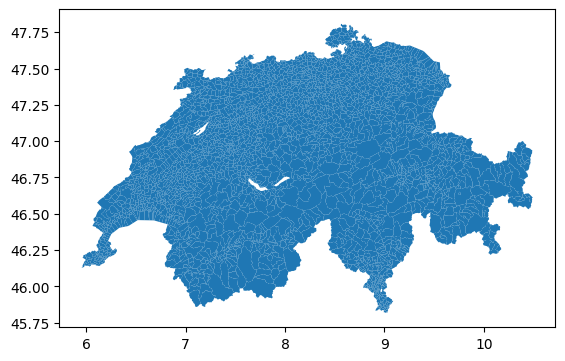

In [27]:
gp.read_parquet("/mnt/wks3/aschneuwl/workspace/data/preprocessed/geo/swiss_localities_with_altitudes.parquet").plot()

In [29]:
all_stations_metadata

,index,stationId,stationName,stationSource,locationLongLat,locationLong,locationLat,locationLongDeg,locationLongMin,locationLatDeg,locationLatMin,locationKmLong,locationKmLat,height,locationLongDec,locationLatDec,height_100,geometry,longitude_m,latitude_m
0,0,TAE,Aadorf / Tänikon,MeteoSchweiz,8°54'/47°29',8°54',47°29',8,54,47,29,710517,259824,539,8.900000,47.483333,53900,b'\x01\x01\x00\x00\x00\xcd\xcc\xcc\xcc\xcc\xcc...,2.710139e+06,1.260199e+06
1,1,TGALL,Allenwinden,Kanton Thurgau,8°57'/47°23',8°57',47°23',8,57,47,23,714225,249135,945,8.950000,47.383333,94500,b'\x01\x01\x00\x00\x00fffff\xe6!@\x11\x11\x11\...,2.714122e+06,1.249154e+06
2,2,WSLBTB,Bettlachstock Bestand,Eidg. Forschungsanstalt WSL,7°25'/47°13',7°25',47°13',7,25,47,13,598396,230398,1100,7.416667,47.216667,110000,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...,2.598336e+06,1.229526e+06
3,3,WSLBTF,Bettlachstock Freiland,Eidg. Forschungsanstalt WSL,7°25'/47°13',7°25',47°13',7,25,47,13,597895,230149,1075,7.416667,47.216667,107500,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...,2.598336e+06,1.229526e+06
4,4,KABAT,Bättwil,Kachelmannwetter GmbH,7°31'/47°29',7°31',47°29',7,31,47,29,605582,259823,366,7.516667,47.483333,36600,b'\x01\x01\x00\x00\x00\x11\x11\x11\x11\x11\x11...,2.605882e+06,1.259177e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,56,VSSAX,Saxon,Kanton Wallis; Dienststelle für Umweltschutz,7°09'/46°08',7°09',46°08',7,9,46,8,577566,109764,460,7.150000,46.133333,46000,b'\x01\x01\x00\x00\x00\x9a\x99\x99\x99\x99\x99...,2.577692e+06,1.109135e+06
694,9,LSN,Lausanne,MeteoSchweiz,6°39'/46°32',6°39',46°32',6,39,46,32,538976,153256,601,6.650000,46.533333,60100,b'\x01\x01\x00\x00\x00\x9a\x99\x99\x99\x99\x99...,2.539498e+06,1.153865e+06
695,13,LBA,Le Brassus,MeteoSchweiz,6°10'/46°33',6°10',46°33',6,10,46,33,501900,156010,1073,6.166667,46.550000,107300,b'\x01\x01\x00\x00\x00\xab\xaa\xaa\xaa\xaa\xaa...,2.502451e+06,1.156205e+06
696,18,BOZ,Orbe,MeteoSchweiz,6°33'/46°44',6°33',46°44',6,33,46,44,531751,176425,438,6.550000,46.733333,43800,b'\x01\x01\x00\x00\x00333333\x1a@\xde\xdd\xdd\...,2.532079e+06,1.176179e+06


In [33]:
assign_stations_to_localities(all_stations_metadata, gp.read_parquet("/mnt/wks3/aschneuwl/workspace/data/preprocessed/geo/swiss_localities_with_altitudes.parquet"), closest=False)

ValueError: 'right_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [48]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

/home/aschneuwl/.pyenv/versions/3.12.3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


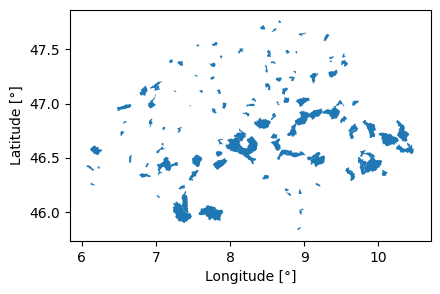

In [62]:
# Create the plot
localized_stations = assign_stations_to_localities(all_stations_metadata, gp.read_parquet("/mnt/wks3/aschneuwl/workspace/data/preprocessed/geo/swiss_localities_with_altitudes.parquet"), list(station_mean[station_mean.time.dt.year == 1983].stationId.unique()), closest=False)
ax = localized_stations.plot(figsize=(5, 3))
# Add an x-axis label
ax.set_xlabel('Longitude [°]', fontsize=10)
ax.set_ylabel('Latitude [°]', fontsize=10)
plt.savefig('weather_stations_1983.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [66]:
station_mean[station_mean.time.dt.year == 1982].stationId.nunique()

159

/home/aschneuwl/.pyenv/versions/3.12.3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


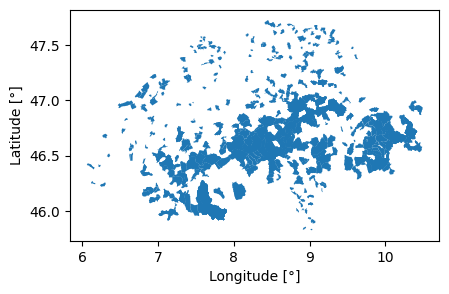

In [63]:
# Create the plot
localized_stations = assign_stations_to_localities(all_stations_metadata, gp.read_parquet("/mnt/wks3/aschneuwl/workspace/data/preprocessed/geo/swiss_localities_with_altitudes.parquet"), list(station_mean[station_mean.time.dt.year == 2023].stationId.unique()), closest=False)
ax = localized_stations.plot(figsize=(5, 3))
# Add an x-axis label
ax.set_xlabel('Longitude [°]', fontsize=10)
ax.set_ylabel('Latitude [°]', fontsize=10)
plt.savefig('weather_stations_2023.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

/home/aschneuwl/.pyenv/versions/3.12.3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

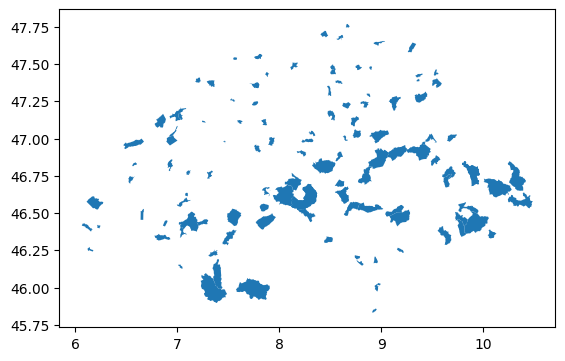

In [36]:

localized_stations.plot()

/home/aschneuwl/.pyenv/versions/3.12.3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

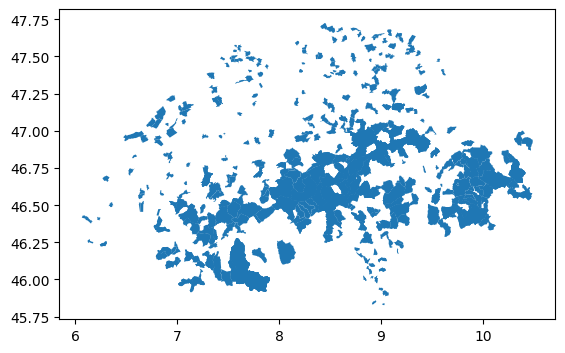

In [37]:
localized_stations = assign_stations_to_localities(all_stations_metadata, gp.read_parquet("/mnt/wks3/aschneuwl/workspace/data/preprocessed/geo/swiss_localities_with_altitudes.parquet"), list(station_mean[station_mean.time.dt.year == 2023].stationId.unique()), closest=False)
localized_stations.plot()